In [29]:
import gym
from torch.optim import Adam
import torch as th
import numpy as np
import matplotlib.pyplot as plt
import csv
from torch import nn
from storage import Buffer
from torch.distributions import Uniform
from torch.distributions import Normal
from torch.nn import functional as f
from copy import deepcopy


[Pendulum problem](https://www.youtube.com/watch?v=1IoN6yCb21s)

### networks.py

In [30]:
class ValueFunction(nn.Module):

    def __init__(
            self,
            input_size,
    ):
        super(ValueFunction, self).__init__()
        self.input_size = input_size

        self.fc1 = nn.Linear(self.input_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, activation):
        activation = f.relu(self.fc1(activation))
        activation = f.relu(self.fc2(activation))
        activation = self.fc3(activation)

        return activation

class GaussianPolicy(nn.Module):

    def __init__(
            self,
            output_size,
            input_size,
            max_action,
            min_action,
            soft_clamp_function=None
    ):
        super(GaussianPolicy, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.soft_clamp_function = soft_clamp_function
        self.max_action = max_action
        self.min_action = min_action
        self.max_log_sig = 2
        self.min_log_sig = -20

        self.fc1 = nn.Linear(self.input_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.mu_head = nn.Linear(256, self.output_size)
        self.log_sig_head = nn.Linear(256, self.output_size)

    def forward(self, activation):

        activation = f.relu(self.fc1(activation))
        activation = f.relu(self.fc2(activation))
        mu = self.mu_head(activation)
        log_sig = self.log_sig_head(activation)
        log_sig = log_sig.clamp(min=self.min_log_sig, max=self.max_log_sig)
        sig = th.exp(log_sig)

        return mu, sig

    def get_action(self, state, eval_deterministic=False):

        mu, sig = self.forward(state)
        if eval_deterministic:
            action = mu
        else:
            gauss = Normal(loc=mu, scale=sig)
            action = gauss.sample()
            action.detach()

        action = self.max_action * th.tanh(action / self.max_action)
        return action

    def get_action_and_log_prob(self, state):

        mu, sig = self.forward(state)
        gauss = Normal(loc=mu, scale=sig)
        action = gauss.sample()
        action.detach()
        action = action.clamp(min=self.min_action, max=self.max_action)
        log_prob = gauss.log_prob(action)

        return action, log_prob

    def r_sample(self, state):

        mu, sig = self.forward(state)
        loc = th.zeros(size=[state.shape[0], 1], dtype=th.float32)
        scale = loc + 1.0
        unit_gauss = Normal(loc=loc, scale=scale)
        gauss = Normal(loc=mu, scale=sig)
        epsilon = unit_gauss.sample()
        action = mu + sig * epsilon
        action = action.requires_grad_()
        action = self.max_action * th.tanh(action / self.max_action)
        log_prob = gauss.log_prob(action.data)

        return action, log_prob

class TanhGaussianPolicy(nn.Module):

    def __init__(
            self,
            output_size,
            input_size,
            max_action,
            min_action,
            soft_clamp_function=None
    ):
        super(TanhGaussianPolicy, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.soft_clamp_function = soft_clamp_function
        self.max_action = max_action
        self.min_action = min_action
        self.max_log_sig = 2
        self.min_log_sig = -20
        self.a_diff = 0.5 * (self.max_action - self.min_action)
        self.a_shift = 0.5 * (self.max_action + self.min_action)
        self.epsilon = 1e-6

        self.fc1 = nn.Linear(self.input_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.mu_head = nn.Linear(256, self.output_size)
        self.log_sig_head = nn.Linear(256, self.output_size)

    def forward(self, activation):

        activation = f.relu(self.fc1(activation))
        activation = f.relu(self.fc2(activation))
        mu = self.mu_head(activation)
        log_sig = self.log_sig_head(activation)
        log_sig = log_sig.clamp(min=self.min_log_sig, max=self.max_log_sig)
        sig = th.exp(log_sig)

        return mu, sig

    def tanh_function(self, a):

        a = self.a_diff * th.tanh(a / self.a_diff) + self.a_shift

        return a

    def tanh_function_derivative(self, a):

        return 1 - (th.tanh(a / self.a_diff) ** 2) + self.epsilon

    def get_action(self, state, eval_deterministic=False):

        mu, sig = self.forward(state)
        if eval_deterministic:
            action = self.tanh_function(mu)
        else:
            gauss = Normal(loc=mu, scale=sig)
            action = gauss.sample()
            action = self.tanh_function(action)

        return action

    def get_action_and_log_prob(self, state):

        mu, sig = self.forward(state)
        gauss = Normal(loc=mu, scale=sig)
        pre_tanh_action = gauss.sample()
        pre_tanh_log_prob = gauss.log_prob(pre_tanh_action)
        action = self.tanh_function(pre_tanh_action)
        log_prob = pre_tanh_log_prob - th.log(self.tanh_function_derivative(pre_tanh_action))

        return action, log_prob

    def r_sample(self, state):

        mu, sig = self.forward(state)
        loc = th.zeros(size=[state.shape[0], 1], dtype=th.float32)
        scale = loc + 1.0
        unit_gauss = Normal(loc=loc, scale=scale)
        epsilon = unit_gauss.sample()
        pre_tanh_action = mu + sig * epsilon
        action = self.tanh_function(pre_tanh_action)

        gauss = Normal(loc=mu, scale=sig)
        pre_tanh_log_prob = gauss.log_prob(pre_tanh_action)
        log_prob = pre_tanh_log_prob - th.log(self.tanh_function_derivative(pre_tanh_action))

        return action, log_prob

### algorithms.py

In [31]:
class ActorCritic:
    def __init__(
            self,
            policy,
            qf,
            env,
            discount,
            qf_optimiser,
            policy_optimiser,
            max_evaluation_episode_length=200,
            num_evaluation_episodes=5,
            num_training_episode_steps=1000,
            batch_size=128,
            buffer_size = 10000,
            eval_deterministic = True,
            training_on_policy = False,
            vf=None,
            vf_optimiser=None
    ):

        self.policy = policy
        self.qf = qf
        self.vf = vf
        self.target_vf = deepcopy(vf)
        self.tau = 1e-2
        self.vf_optimiser = vf_optimiser
        self.qf_optimiser = qf_optimiser
        self.policy_optimiser = policy_optimiser
        self.env = env
        self.discount = discount
        self.batch_size = batch_size
        self.max_evaluation_episode_length = max_evaluation_episode_length
        self.num_evaluation_episodes = num_evaluation_episodes
        self.num_training_episode_steps = num_training_episode_steps
        self.training_on_policy = training_on_policy
        self.buffer = Buffer(buffer_size=buffer_size)
        self.loss = nn.MSELoss()
        self.pretraining_policy = Uniform(high=th.Tensor([policy.max_action]), low=th.Tensor([policy.min_action]))
        self.eval_deterministic = eval_deterministic

        self.R_av = None
        self.R_tot = 0

    def reset(self):
        self.state = th.from_numpy(self.env.reset()).float()

    def evaluate(self, render=False):

        total_return = 0

        for _ in range(self.num_evaluation_episodes):
            state = th.from_numpy(self.env.reset()).float()
            episode_return = 0

            for _ in range(self.max_evaluation_episode_length):
                action = self.policy.get_action(state, self.eval_deterministic)
                action = np.array([action.item()])

                if render:
                    self.env.render()
                state, reward, terminal, _ = self.env.step(action)
                state = th.from_numpy(state).float()

                episode_return += reward

                if terminal:
                    break

            total_return += episode_return

        self.average_return = total_return/self.num_evaluation_episodes

    def sample_episode(self, exploration_mode=False):

        self.reset()
        state = self.state

        for _ in range(self.num_training_episode_steps):

            if exploration_mode:
                action = self.pretraining_policy.sample()
            else:
                action = self.policy.get_action(state)
            next_state, reward, terminal, _ = self.env.step(action.numpy())
            next_state = th.from_numpy(next_state).float()
            reward = th.Tensor([reward])
            terminal = th.Tensor([terminal])

            self.buffer.add(state=state,
                            action=action,
                            reward=reward,
                            next_state=next_state,
                            terminal=terminal)

            state = next_state
            if terminal:
                self.reset()
                state = self.state

    def env_step(self):

        state = self.state
        action = self.policy.get_action(state)
        next_state, reward, terminal, _ = self.env.step(action.numpy())
        next_state = th.from_numpy(next_state).float()
        reward = th.Tensor([reward])
        terminal = th.Tensor([terminal])

        self.buffer.add(state=state,
                        action=action,
                        reward=reward,
                        next_state=next_state,
                        terminal=terminal)

        self.state = next_state

    def train_score(self):
        if self.training_on_policy:
            batch = self.buffer.whole_batch()
            self.buffer.clear()
        else:
            batch = self.buffer.random_batch(self.batch_size)
        states = batch['states']
        actions = batch['actions']
        rewards = batch['rewards']
        next_states = batch['next_states']
        terminals = batch['terminals']

        new_actions, log_pis = self.policy.get_action_and_log_prob(states)
        values = self.vf(states)
        state_actions = th.cat((states, actions), 1)
        q_values = self.qf(state_actions)
        next_values = self.target_vf(next_states)
        new_state_actions = th.cat((states, new_actions), 1)
        new_q_values = self.qf(new_state_actions)

        """
        Value (Critic) Losses:
        """
        v_targets = new_q_values
        vf_loss = (v_targets.detach() - values).pow(2).mean()

        q_targets = rewards + self.discount * (1 - terminals) * next_values
        qf_loss = (q_targets.detach() - q_values).pow(2).mean()


        """
        Policy (Actor) Losses: TO COMPLETE IN EXERCISE II.2b
        """
        advantage = new_q_values - values
        policy_loss = (log_pis * (log_pis - advantage.detach())).mean()

        """
        Gradient Updates
        """
        self.qf_optimiser.zero_grad()
        qf_loss.backward()
        self.qf_optimiser.step()

        self.vf_optimiser.zero_grad()
        vf_loss.backward()
        self.vf_optimiser.step()

        self.policy_optimiser.zero_grad()
        policy_loss.backward()
        self.policy_optimiser.step()

        self.soft_update()

    def train_reparametrisation(self):

        if self.training_on_policy:
            batch = self.buffer.whole_batch()
            self.buffer.clear()
        else:
            batch = self.buffer.random_batch(self.batch_size)
        states = batch['states']
        actions = batch['actions']
        rewards = batch['rewards']
        next_states = batch['next_states']
        terminals = batch['terminals']

        state_actions = th.cat((states, actions), 1)
        q_pred = self.qf(state_actions)
        v_pred = self.vf(states)
        new_actions, log_pis = self.policy.r_sample(states)

        """
        Value (Critic) Losses:
        """
        target_v_values = self.target_vf(next_states)
        q_target = rewards + (1. - terminals) * self.discount * target_v_values
        qf_loss = self.loss(q_pred, q_target.detach())

        new_state_actions = th.cat((states, new_actions), 1)
        q_new_actions = self.qf(new_state_actions)
        v_target = q_new_actions
        vf_loss = self.loss(v_pred, v_target.detach())

        """
        Policy (Actor) Loss: TO COMPLETE IN EXERCISE II.3c     
        """
        policy_loss = (log_pis - q_new_actions).mean()


        """
        Gradient Updates
        """
        self.qf_optimiser.zero_grad()
        qf_loss.backward()
        self.qf_optimiser.step()

        self.vf_optimiser.zero_grad()
        vf_loss.backward()
        self.vf_optimiser.step()

        self.policy_optimiser.zero_grad()
        policy_loss.backward()
        self.policy_optimiser.step()

        self.soft_update()


    def soft_update(self):
        for target_param, param in zip(self.target_vf.parameters(), self.vf.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - self.tau) + param.data * self.tau
            )

In [33]:
def run_experiment(s):

    policy = TanhGaussianPolicy(
        max_action=max_action,
        min_action=min_action,
        input_size=state_dim,
        output_size=action_dim
    )
    policy_optimiser = Adam(policy.parameters(), lr=lr)

    qf = ValueFunction(
        input_size=state_dim + action_dim,
    )
    qf_optimiser = Adam(qf.parameters(), lr=lr)

    vf = ValueFunction(
        input_size=state_dim,
    )
    vf_optimiser = Adam(vf.parameters(), lr=lr)

    algorithm = ActorCritic(
        policy=policy,
        policy_optimiser=policy_optimiser,
        qf=qf,
        qf_optimiser=qf_optimiser,
        vf=vf,
        vf_optimiser=vf_optimiser,
        env=env,
        discount=discount
    )

    for _ in range(num_pretrain_episodes):
        algorithm.sample_episode(exploration_mode=True)

    for e in range(num_epochs):

        algorithm.evaluate()
        print('Epoch: {}, Average Test Return: {}'.format(e, algorithm.average_return))
        results[e, s] = algorithm.average_return
        algorithm.reset()

        for n in range(num_training_updates_per_epoch):
            algorithm.env_step()
            if training_mode == 'Score':
                algorithm.train_score()
            else:
                algorithm.train_reparametrisation()


    algorithm.evaluate(render=render_agent)
    print('Epoch: {}, Average Test Return: {}'.format(e+1, algorithm.average_return))
    results[e+1, s] = algorithm.average_return

In [34]:
def write_to_file(mean, std):
    with open('PartII_{}_{}_trials_{}_epochs.csv'.format(training_mode, number_of_trials, num_epochs), 'w') as resultFile:
        wr = csv.writer(resultFile)
        mean.insert(0, 'Mean Returns')
        std.insert(0, 'Standard Deviation')
        data = [mean, std]
        data = list(map(list, zip(*data)))
        wr.writerows(data)

In [36]:
# Initialise Environment
env = gym.make("Pendulum-v0").unwrapped
max_action = env.action_space.high[0]
min_action = env.action_space.low[0]
state_dim = int(env.observation_space.shape[0])
action_dim = int(env.action_space.shape[0])
# Options: 'Score' trains the policy using the score function and 'Reparam' trains using the reparametrisation trick.
training_mode = 'Reparam' 
number_of_trials = 1
save_data = True
render_agent = False

# Set parameters
num_epochs = 5
num_pretrain_episodes = 1
num_training_updates_per_epoch = 200
lr = 3e-4
discount = 0.99

# Initialise data logger
results = np.zeros((num_epochs + 1, number_of_trials))

Epoch: 0, Average Test Return: -1392.5659115334288
Epoch: 1, Average Test Return: -1523.834288354346
Epoch: 2, Average Test Return: -1712.4369300894352
Epoch: 3, Average Test Return: -1672.739151908319
Epoch: 4, Average Test Return: -1569.5727207161713
Epoch: 5, Average Test Return: -1231.856655457303


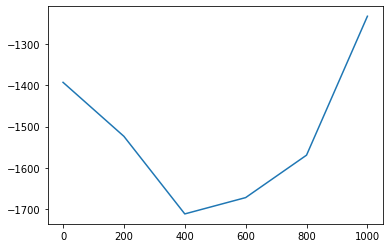

In [37]:
if __name__ == "__main__":

    for s in range(number_of_trials):
        th.manual_seed(s+1)
        run_experiment(s)

    mean_returns = results.mean(axis=1)
    std_returns = results.std(axis=1)
    training_steps = np.linspace(0, num_epochs * num_training_updates_per_epoch, num=num_epochs+1)
    plt.plot(training_steps, mean_returns)
    plt.fill_between(training_steps, mean_returns + std_returns, mean_returns - std_returns, alpha=0.3)
    plt.show()

    if save_data:
        write_to_file(mean_returns.tolist(), std_returns.tolist())